# Turing model (brusselator)

Cross, Michael, and Henry Greenside. Pattern formation and dynamics in nonequilibrium systems. Cambridge University Press, 2009.

## Dynamics equations

\begin{equation}
\dot{u} = D_u \nabla^2 u + a + u^2 v - u(b+1)
\end{equation}

\begin{equation}
\dot{v} = D_v \nabla^2 v + b u - u^2 v
\end{equation}    

In [1]:
import numpy as np
import matplotlib.patches as patches
from tqdm import tqdm # library to visualize the progress status of a python loop

from scipy.linalg import toeplitz
from scipy.integrate import odeint

from euler_scheme_1d_with_growth.diffusion_equation import *
from euler_scheme_1d_with_growth.matplotlib_defaults import *

In [2]:
Du = 0.2 
Dv = 0.8 
a = 3
b = 8

noise_level = 0.2 # noise level for initial perturbation

In [3]:
## Numerical parameters
L = 8 # system size
T = 100 # maximal integration time
nspace = 256 # number of spatial grid points
ntime = 100 # number of time steps

In [4]:
"""
Brusselator model
d_t u = Du Lap(u) + a - (b+1)*u+ u**2 * v 
d_t v = Dv Lap(v) + b*u - u**2 * v
"""

# reaction functions
def Ru(u,v):
    return ( u**2 * v + a - (b+1)*u)
def Rv(u,v):
    return (-u**2 * v + b * u)

In [5]:
# second derivative stencil with periodic boundary conditions: 5-point stencil
def d5_stencil(x):
    dx = x[1] - x[0]
    z = np.zeros_like(x)
    z[0]  = -30
    z[1]  =  16
    z[2]  = -1
    z[-1] = 16
    z[-2] = -1
    D = toeplitz(z) # Toeplitz matrix representing Laplacian operator
    return  D / (12.0*dx**2)

In [6]:
# final equations
def time_deriv(y, t0, D):
    u,v = np.split(y,2)
    dudt = Ru(u,v) + Du * np.dot(D, u)
    dvdt = Rv(u,v) + Dv * np.dot(D, v)
    return np.concatenate([dudt, dvdt]).ravel()

In [7]:
###############
# space-time grid
t = np.linspace(0, T, ntime) # time points
dx = L/nspace # spatial bin size
x = np.linspace(0, L, nspace) # spatial grid points

# stencil for second derivative matrix
D = d5_stencil(x)

# initial conditions + small perturbation
u0 = a*np.ones_like(x)
v0 = (b/a)*np.ones_like(x)

noise_u = np.random.randn(nspace)
noise_v = np.random.randn(nspace)
 
u0 += (noise_level * noise_u/np.max(np.absolute(noise_u)))
v0 += (noise_level * noise_v/np.max(np.absolute(noise_v)))

# concatenate u,v and make a 1D array
y0 = np.concatenate([u0,v0]).ravel()
# assert(all(y0>=0))

# time evolution (using built-in ODE solver with prescribed relative and absolute tolerances)
soln = odeint(time_deriv, y0, t, args=((D,)), 
        rtol=1e-3, atol=1e-6)

# parse solution
u, v = np.split(soln, 2, axis=1)

# Plot results

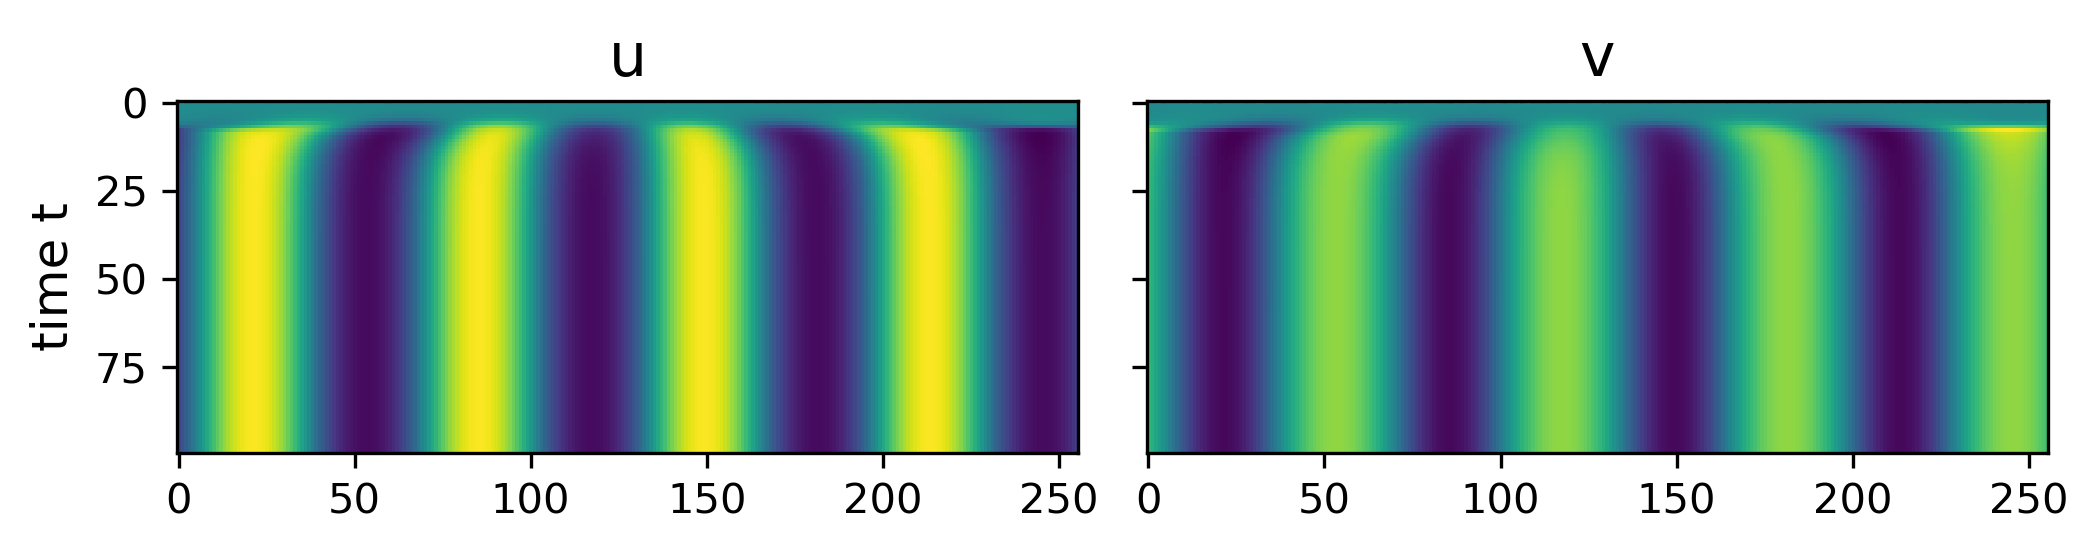

In [8]:
nrows, ncols = 1, 2

fig, ax = plt.subplots(nrows, ncols, figsize=(default_figsize["large"][0], default_figsize["large"][1]/4), sharex=True, sharey=True)

ax[0].imshow( u )
ax[0].set_title( 'u' )
ax[0].set_ylabel('time t')

ax[1].imshow( v )
ax[1].set_title( 'v' )

plt.tight_layout()
plt.show()

In [9]:
tmax = T
dt   = T / ntime

In [10]:
u[0].shape

(256,)

In [11]:
x.shape

(256,)

In [12]:
ntime

100

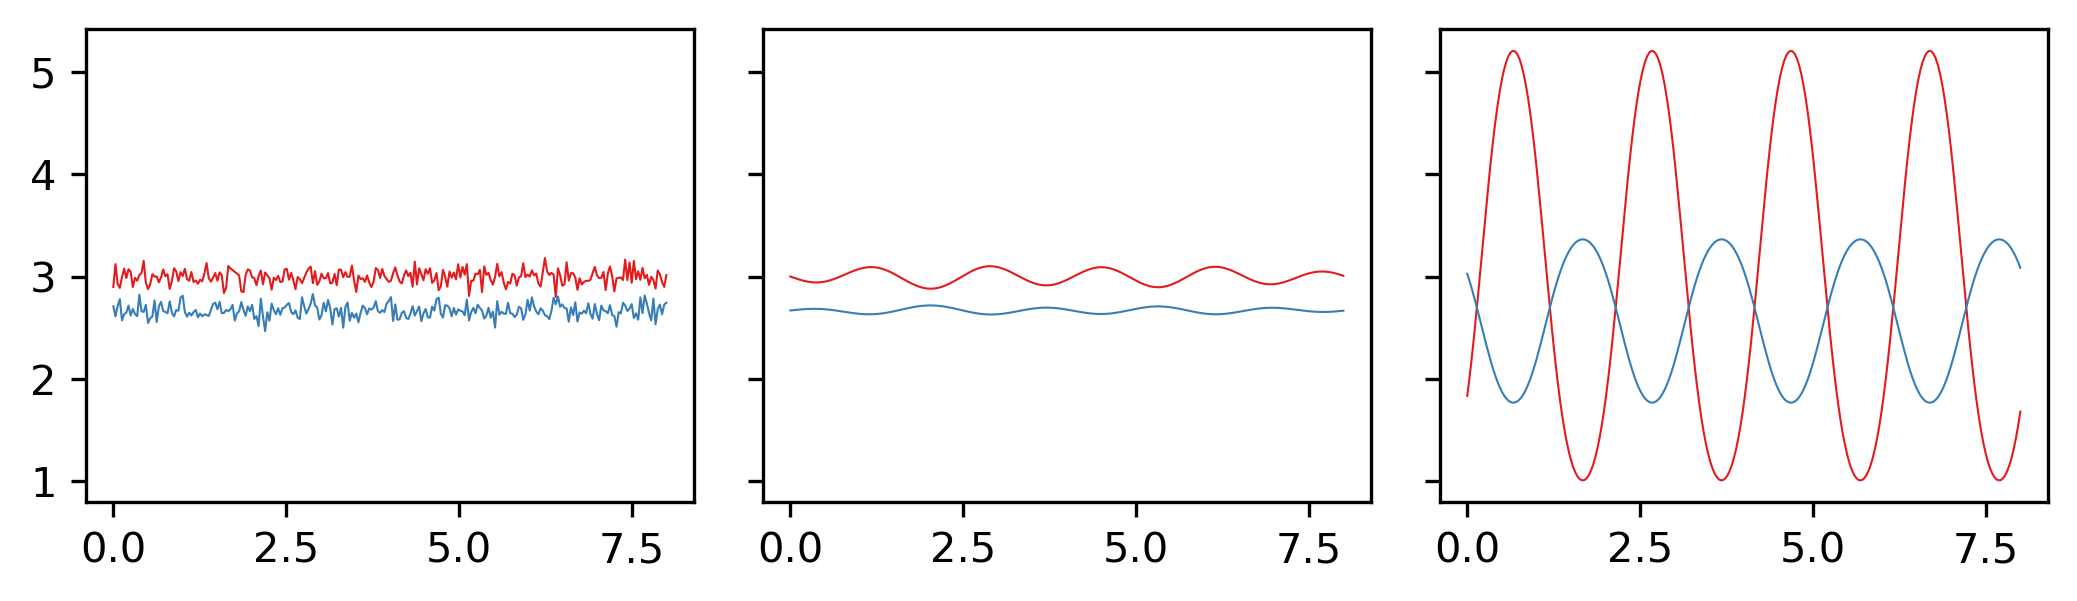

In [13]:
t_to_plot = [0.0, tmax/30, tmax-1]
nrows, ncols = 1, len( t_to_plot )
colors = plt.cm.Set1.colors

fig, ax = plt.subplots(nrows, ncols, figsize=(default_figsize["large"][0], default_figsize["large"][1]/4), sharex=True, sharey=True, dpi=300)

for i, it in enumerate( t_to_plot ): 
    ax[i].plot(x, u[ int(it/dt) ], color=colors[0], label=f't={t}')
    ax[i].plot(x, v[ int(it/dt) ], color=colors[1], label=f't={t}')

plt.tight_layout()
plt.savefig('fig/turing.pdf')
plt.show()